$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\derp}[2]{\frac{ \partial #1 }{ \partial #2 }}$

$\newcommand{\E}{\bb{E}}$

# Learning Dynamics

In [1]:
from core.systems import InvertedPendulum

In [2]:
ip = InvertedPendulum(m=0.25, l=0.5)
ip_est = InvertedPendulum(m=0.24, l=0.48)

In [3]:
from numpy import identity
from core.controllers import FBLinController, LQRController

Q = identity(2)
R = identity(1)

lqr_oracle = LQRController.build(ip, Q, R)
fb_lin_oracle = FBLinController(ip, lqr_oracle)

In [4]:
from numpy import array, linspace

x_0 = array([1, 0])
ts = linspace(0, 10, 1000)

In [5]:
xs, _ = ip.simulate(x_0, fb_lin_oracle, ts)

In [6]:
from matplotlib.pyplot import show, subplots

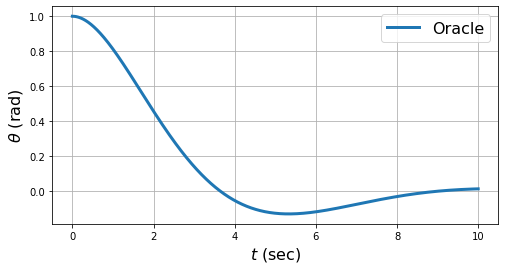

In [7]:
fig, ax = subplots(figsize=(8, 4))
ax.plot(ts, xs[:, 0], linewidth=3, label='Oracle')
ax.grid()
ax.legend(fontsize=16)
ax.set_xlabel('$t$ (sec)', fontsize=16)
ax.set_ylabel('$\\theta$ (rad)', fontsize=16)
show()

In [8]:
lqr_est = LQRController.build(ip_est, Q, R)
fb_lin_est = FBLinController(ip_est, lqr_est)

In [9]:
xs, us = ip.simulate(x_0, fb_lin_est, ts)

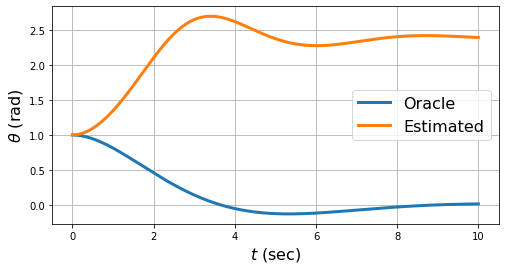

In [10]:
ax.plot(ts, xs[:, 0], linewidth=3, label='Estimated')
ax.legend(fontsize=16)
fig

In [11]:
from numpy import arange, dot, reshape, zeros
from numpy.linalg import solve

def differentiate(xs, ts, L=3):
    half_L = (L - 1) // 2
    b = zeros(L)
    b[1] = 1

    def diff(xs, ts):
        t_0 = ts[half_L]
        t_diffs = reshape(ts - t_0, (L, 1))
        pows = reshape(arange(L), (1, L))
        A = (t_diffs ** pows).T
        w = solve(A, b)
        return dot(w, xs)

    return array([diff(xs[k - half_L:k + half_L + 1], ts[k - half_L:k + half_L + 1]) for k in range(half_L, len(ts) - half_L)])

In [12]:
class ResidualModel:
    def eval_dot(self, input):
        pass
    
    def fit(self, inputs, residuals, batch_size=1, num_epochs=1, validation_split=0):
        pass

In [13]:
from keras import Sequential
from keras.layers import Dense
from numpy.random import permutation
    
class KerasResidualModel(ResidualModel):
    def __init__(self, d_in, d_hidden, d_out, optimizer='sgd', loss='mean_absolute_error'):
        model = Sequential()
        model.add(Dense(d_hidden, input_shape=(d_in,), activation='relu'))
        model.add(Dense(d_out))
        model.compile(optimizer, loss)
        self.model = model
        
    def eval_dot(self, input):
        return self.model.predict(array([input]))[0]
    
    def shuffle(self, inputs, residuals):
        perm = permutation(len(inputs))
        return inputs[perm], residuals[perm]
    
    def fit(self, inputs, residuals, batch_size=1, num_epochs=1, validation_split=0):
        inputs, residuals = self.shuffle(inputs, residuals)
        self.model.fit(inputs, residuals, batch_size=batch_size, epochs=num_epochs, validation_split=validation_split)

Using TensorFlow backend.


In [14]:
from numpy import concatenate
from core.dynamics import Dynamics

class LearnedDynamics(Dynamics):
    def __init__(self, dynamics, res_model):
        self.dynamics = dynamics
        self.res_model = res_model
        
    def process(self, x, u, t):
        return concatenate([x, u, array([t])])
        
    def eval(self, x, t):
        return self.dynamics.eval(x, t)
    
    def eval_dot(self, x, u, t):
        return self.dynamics.eval_dot(x, u, t) + self.res_model.eval_dot(self.process(x, u, t))
        
    def process_episode(self, xs, us, ts, window=3):
        half_window = (window - 1) // 2
        xs = xs[:len(us)]
        ts = ts[:len(us)]
        
        inputs = array([self.process(x, u, t) for x, u, t in zip(xs, us, ts)])
        
        reps = array([self.dynamics.eval(x, t) for x, t in zip(xs, ts)])
        rep_dots = differentiate(reps, ts)
        
        rep_dot_noms = array([self.dynamics.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
        
        inputs = inputs[half_window:-half_window]
        rep_dot_noms = rep_dot_noms[half_window:-half_window]
        
        residuals = rep_dots - rep_dot_noms
        
        return inputs, residuals
    
    def init_data(self, d_in, d_out):
        return [zeros((0, d_in)), zeros((0, d_out))]
    
    def aggregate_data(self, old_data, new_data):
        return [concatenate(old, new) for old, new in zip(old_data, new_data)]
    
    def fit(self, data, batch_size=1, num_epochs=1, validation_split=0):
        inputs, residuals = data
        self.res_model.fit(inputs, residuals, batch_size, num_epochs, validation_split)

In [15]:
from tensorflow.logging import ERROR, set_verbosity
set_verbosity(ERROR)

d_in = 4
d_hidden = 20
d_out = 2

res_model = KerasResidualModel(d_in, d_hidden, d_out, optimizer='adam')
ip_learned = LearnedDynamics(ip_est, res_model)
data = ip_learned.process_episode(xs, us, ts)
ip_learned.fit(data, num_epochs=10, validation_split=0.2, batch_size=1)

Train on 797 samples, validate on 200 samples
Epoch 1/10
797/797 [==============================] - 2s 2ms/step - loss: 0.3444 - val_loss: 0.0410
Epoch 2/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0270 - val_loss: 0.0155
Epoch 3/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0205 - val_loss: 0.0186
Epoch 4/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0176 - val_loss: 0.0238
Epoch 5/10
797/797 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0129
Epoch 6/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0164 - val_loss: 0.0145
Epoch 7/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0159 - val_loss: 0.0123
Epoch 8/10
797/797 [==============================] - 1s 1ms/step - loss: 0.0157 - val_loss: 0.0185
Epoch 9/10
797/797 [==============================] - 1s 1ms/step - loss: 0.0145 - val_loss: 0.0200
Epoch 10/10
797/797 [==============================] -

In [16]:
x_dots = array([array([ip.eval_dot(x, u, t), ip_est.eval_dot(x, u, t), ip_learned.eval_dot(x, u, t)]) for x, u, t in zip(xs, us, ts)])

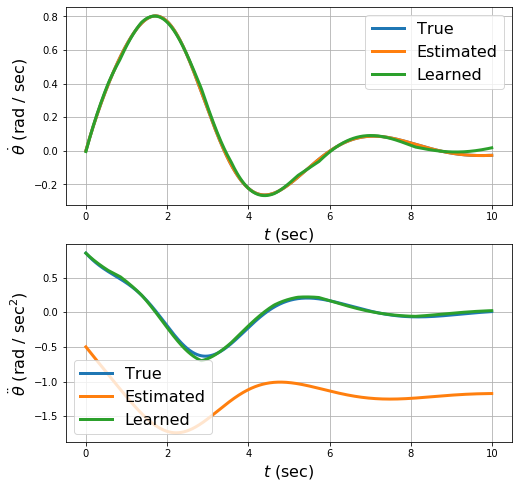

In [17]:
x_dots = array([array([ip.eval_dot(x, u, t), ip_est.eval_dot(x, u, t), ip_learned.eval_dot(x, u, t)]) for x, u, t in zip(xs, us, ts)])

_, (ax_1, ax_2) = subplots(2, figsize=(8, 8))

ax_1.plot(ts[:-1], x_dots[:, 0, 0], linewidth=3, label='True')
ax_1.plot(ts[:-1], x_dots[:, 1, 0], linewidth=3, label='Estimated')
ax_1.plot(ts[:-1], x_dots[:, 2, 0], linewidth=3, label='Learned')
ax_1.grid()
ax_1.legend(fontsize=16)
ax_1.set_xlabel('$t$ (sec)', fontsize=16)
ax_1.set_ylabel('$\\dot{\\theta}$ (rad / sec)', fontsize=16)


ax_2.plot(ts[:-1], x_dots[:, 0, 1], linewidth=3, label='True')
ax_2.plot(ts[:-1], x_dots[:, 1, 1], linewidth=3, label='Estimated')
ax_2.plot(ts[:-1], x_dots[:, 2, 1], linewidth=3, label='Learned')
ax_2.grid()
ax_2.legend(fontsize=16)
ax_2.set_xlabel('$t$ (sec)', fontsize=16)
ax_2.set_ylabel('$\\ddot{\\theta}$ (rad / sec$^2$)', fontsize=16)

show()

In [18]:
class ResidualAffineModel:
    def eval_drift(self, drift_input):
        pass
    
    def eval_act(self, act_input):
        pass
    
    def fit(self, drift_inputs, act_inputs, us, residuals, batch_size=1, num_epochs=1, validation_split=0):
        pass

In [19]:
from keras import Model
from keras.layers import Add, Dot, Input, Reshape

class KerasResidualAffineModel:
    def __init__(self, d_drift_in, d_act_in, d_hidden, m, d_out, optimizer='sgd', loss='mean_absolute_error'):
        drift_model = Sequential()
        drift_model.add(Dense(d_hidden, input_shape=(d_drift_in,), activation='relu'))
        drift_model.add(Dense(d_out, activation='relu'))
        self.drift_model = drift_model

        drift_inputs = Input((d_drift_in,))
        drift_residuals = self.drift_model(drift_inputs)
        
        act_model = Sequential()
        act_model.add(Dense(d_hidden, input_shape=(d_act_in,), activation='relu'))
        act_model.add(Dense(d_out * m, activation='relu'))
        act_model.add(Reshape((d_out, m)))
        self.act_model = act_model
        
        act_inputs = Input((d_act_in,))
        act_residuals = self.act_model(act_inputs)
        
        us = Input((m,))
        
        residuals = Add()([drift_residuals, Dot([2, 1])([act_residuals, us])])
        model = Model([drift_inputs, act_inputs, us], residuals)
        model.compile(optimizer, loss)
        self.model = model
        
    def eval_drift(self, drift_input):
        return self.drift_model.predict(array([drift_input]))[0]
    
    def eval_act(self, act_input):
        return self.act_model.predict(array([act_input]))[0]
    
    def shuffle(self, drift_inputs, act_inputs, us, residuals):
        perm = permutation(len(residuals))
        return drift_inputs[perm], act_inputs[perm], us[perm], residuals[perm]
    
    def fit(self, drift_inputs, act_inputs, us, residuals, batch_size=1, num_epochs=1, validation_split=0):
        drift_inputs, act_inputs, us, residuals = self.shuffle(drift_inputs, act_inputs, us, residuals)
        self.model.fit([drift_inputs, act_inputs, us], residuals, batch_size=batch_size, epochs=num_epochs, validation_split=validation_split)

In [20]:
from core.dynamics import AffineDynamics

class LearnedAffineDynamics(AffineDynamics):
    def __init__(self, affine_dynamics, res_aff_model):
        self.dynamics = affine_dynamics
        self.res_model = res_aff_model
        
    def process_drift(self, x, t):
        return concatenate([x, array([t])])
        
    def process_act(self, x, t):
        return concatenate([x, array([t])])

    def eval(self, x, t):
        return self.dynamics.eval(x, t)
    
    def drift(self, x, t):
        return self.dynamics.drift(x, t) + self.res_model.eval_drift(self.process_drift(x, t))
    
    def act(self, x, t):
        return self.dynamics.act(x, t) + self.res_model.eval_act(self.process_act(x, t))
    
    def process_episode(self, xs, us, ts, window=3):
        half_window = (window - 1) // 2
        xs = xs[:len(us)]
        ts = ts[:len(us)]
        
        drift_inputs = array([self.process_drift(x, t) for x, t in zip(xs, ts)])
        act_inputs = array([self.process_act(x, t) for x, t in zip(xs, ts)])
        
        reps = array([self.dynamics.eval(x, t) for x, t in zip(xs, ts)])
        rep_dots = differentiate(reps, ts)
        
        rep_dot_noms = array([self.dynamics.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
        
        drift_inputs = drift_inputs[half_window:-half_window]
        act_inputs = act_inputs[half_window:-half_window]
        rep_dot_noms = rep_dot_noms[half_window:-half_window]
        
        residuals = rep_dots - rep_dot_noms
        
        return drift_inputs, act_inputs, us, residuals
    
    def init_data(self, d_drift_in, d_act_in, m, d_out):
        return [zeros((0, d_drift_in)), zeros((0, d_act_in)), zeros((0, m)), zeros((0, d_out))]
    
    def fit(self, data, batch_size=1, num_epochs=1, validation_split=0):
        drift_inputs, act_inputs, us, residuals = data
        self.res_model.fit(drift_inputs, act_inputs, us, residuals, batch_size, num_epochs, validation_split)

In [21]:
d_drift_in = 3
d_act_in = 3
d_hidden = 20
m = 1
d_out = 2

res_aff_model = KerasResidualAffineModel(d_drift_in, d_act_in, d_hidden, m, d_out, optimizer='adam')
ip_learned = LearnedAffineDynamics(ip_est, res_aff_model)
data = ip_learned.process_episode(xs, us, ts)
ip_learned.fit(data, num_epochs=10, validation_split=0.2, batch_size=1)

Train on 797 samples, validate on 200 samples
Epoch 1/10
797/797 [==============================] - 2s 3ms/step - loss: 0.0874 - val_loss: 0.0590
Epoch 2/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0484 - val_loss: 0.0500
Epoch 3/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0370 - val_loss: 0.0300
Epoch 4/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0278 - val_loss: 0.0285
Epoch 5/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0216 - val_loss: 0.0169
Epoch 6/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0192 - val_loss: 0.0185
Epoch 7/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0189 - val_loss: 0.0174
Epoch 8/10
797/797 [==============================] - 2s 2ms/step - loss: 0.0172 - val_loss: 0.0130
Epoch 9/10
797/797 [==============================] - 1s 2ms/step - loss: 0.0172 - val_loss: 0.0141
Epoch 10/10
797/797 [==============================] -

In [22]:
x_dots = array([array([ip.eval_dot(x, u, t), ip_est.eval_dot(x, u, t), ip_learned.eval_dot(x, u, t)]) for x, u, t in zip(xs, us, ts)])

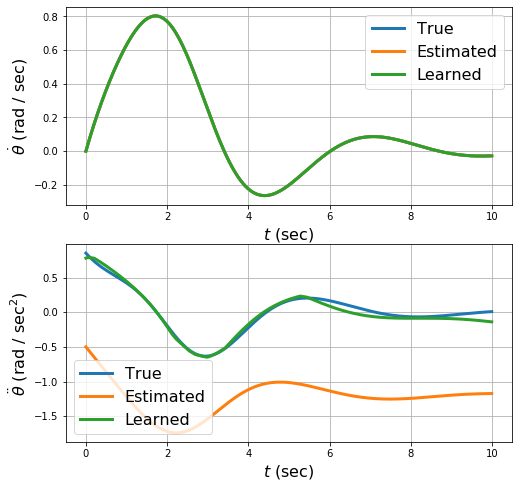

In [23]:
_, (ax_1, ax_2) = subplots(2, figsize=(8, 8))

ax_1.plot(ts[:-1], x_dots[:, 0, 0], linewidth=3, label='True')
ax_1.plot(ts[:-1], x_dots[:, 1, 0], linewidth=3, label='Estimated')
ax_1.plot(ts[:-1], x_dots[:, 2, 0], linewidth=3, label='Learned')
ax_1.grid()
ax_1.legend(fontsize=16)
ax_1.set_xlabel('$t$ (sec)', fontsize=16)
ax_1.set_ylabel('$\\dot{\\theta}$ (rad / sec)', fontsize=16)


ax_2.plot(ts[:-1], x_dots[:, 0, 1], linewidth=3, label='True')
ax_2.plot(ts[:-1], x_dots[:, 1, 1], linewidth=3, label='Estimated')
ax_2.plot(ts[:-1], x_dots[:, 2, 1], linewidth=3, label='Learned')
ax_2.grid()
ax_2.legend(fontsize=16)
ax_2.set_xlabel('$t$ (sec)', fontsize=16)
ax_2.set_ylabel('$\\ddot{\\theta}$ (rad / sec$^2$)', fontsize=16)

show()